In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import gymnasium as gym
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def mlp(hidden_sizes, activation = nn.ReLU, output_activation = nn.Identity):
    # Builds a simple MLP next
    
    layers = []

    for i in range(len(hidden_sizes) - 1):
        activ = activation if i < len(hidden_sizes) - 2 else output_activation
        layers += [nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), activ()]

    return nn.Sequential(*layers)

In [5]:
class REINFORCEBaselineTrainer:
    ''' REINFORCE algorithm with baseline'''

    def __init__(self, 
                 env, 
                 pi_net_sizes = [32], 
                 vf_net_sizes = [32],
                 ):

        self.env = env
        self.nS = env.observation_space.shape[0] # dim of observations space
        self.nA = env.action_space.n             # dim of action space
        
        # policy neural net
        self.pi_mlp = mlp([self.nS] + pi_net_sizes + [self.nA])
        

        # value function neural net
        self.vf_mlp = mlp([self.nS] + vf_net_sizes + [1], output_activation=nn.ReLU)
        

    
    
    def policy(self, obs):
        logits = self.pi_mlp(obs)
        return Categorical(logits=logits)
    
    def sample_action(self, obs):
        return self.policy(obs).sample().item()
    
    def compute_pi_loss(self, observations, actions, returns, values):
        """
        In:
            observations - (T,nS) tensor
            actions      - (T, 1) tensor
            values       - (T, 1) tensor
        Out:
            policy net scalar loss
        """
        logp = self.policy(observations).log_prob(actions)
        return -(logp * (returns - values.detach())).mean() # detach values to freeze its gradients, only logp propagates back
    
    
    def compute_vf_loss(self, returns, values):
        """
        In:
            observations - (T,nS) tensor
            returns      - (T, 1) tensor
            values       - (T, 1) tensor
        Out:
            value functions net scalar loss
        """
        return ((returns - values)**2).mean()
    
    
    def compute_returns(self, rewards):
        returns = torch.zeros(len(rewards))
        returns[-1] = rewards[-1]
        
        for i in reversed(range(len(rewards)-1)):
            returns[i] = rewards[i] + returns[i+1]
        
        return returns


    def generate_batch(self, batch_size):
        '''
        In:
            batch_size - total number of steps
        Out:
            batch_obs - (B, nS)
            batch_act, batch_returns - (B,)
            batch_tot_ep_rew, batch_ep_lens - lists of length num_episodes
        '''
        # logging
        batch_obs = []
        batch_act = []
        batch_returns = []
        batch_tot_ep_rew = []
        batch_ep_lens = []

        episode_rew = [] 

        obs, info = self.env.reset()
        

        while len(batch_returns) <= batch_size:
            # sample action
            action = self.sample_action(torch.as_tensor(obs))

            # transition to next state
            next_obs, reward, terminated, truncated, info = self.env.step(action)

            # logging
            batch_obs.append(obs)
            batch_act.append(action)
            episode_rew.append(reward)


            if not (terminated or truncated):
                obs = next_obs
            else:
                returns = self.compute_returns(episode_rew)
                episode_rew = []
                
                batch_returns += returns

                batch_tot_ep_rew.append(returns[0])
                batch_ep_lens.append(len(returns))

                obs, info = self.env.reset()
        
        self.env.close()
                
        
        batch_obs = torch.from_numpy(np.stack(batch_obs))
        batch_act = torch.tensor(batch_act)
        batch_returns = torch.tensor(batch_returns)


        return batch_obs, batch_act, batch_returns, batch_tot_ep_rew, batch_ep_lens



    

    def train_one_epoch(self, epoch_logs, pi_optimizer, vf_optimizer):
        
        batch_obs, batch_act, batch_returns, batch_tot_ep_rew, batch_ep_lens = epoch_logs

        pi_optimizer.zero_grad()
        vf_optimizer.zero_grad()

        values = self.vf_mlp(batch_obs)

        pi_loss = self.compute_pi_loss(batch_obs, batch_act, batch_returns, values)
        vf_loss = self.compute_vf_loss(batch_returns, values)

        pi_loss.backward()
        vf_loss.backward()

        pi_optimizer.step()
        vf_optimizer.step()

        return pi_loss.item(), vf_loss.item()


    def train(self, n_epochs, batch_size = 5000, pi_lr = 1e-2, vf_lr = 1e-2):

        # logging
        total_rewards = []
        vf_losses = []

        pi_optimizer = Adam(self.pi_mlp.parameters(), lr = pi_lr)
        vf_optimizer = Adam(self.vf_mlp.parameters(), lr = vf_lr)

        for i in tqdm(range(n_epochs)):
            epoch_logs = self.generate_batch(batch_size)
            pi_loss, vf_loss = self.train_one_epoch(epoch_logs, pi_optimizer, vf_optimizer)
            
            # logging
            batch_obs, batch_act, batch_returns, batch_tot_ep_rew, batch_ep_lens = epoch_logs
            ave_tot_rew = sum(batch_tot_ep_rew)/len(batch_tot_ep_rew)
            total_rewards.append(ave_tot_rew)
            
            vf_losses.append(vf_loss)
            
            print(f"Batch {i+1:>3} average return: {ave_tot_rew:>3.0f} | vf loss: {vf_loss:>8.0f}")

        
        # clear_output()
        
        return total_rewards, vf_losses


# Cart Pole

In [137]:
env = gym.make('CartPole-v1')
R = REINFORCEBaselineTrainer(env, vf_net_sizes = [32])

In [138]:
total_rewards, vf_losses = R.train(n_epochs=200, pi_lr = 1e-2, vf_lr = 5e-2)

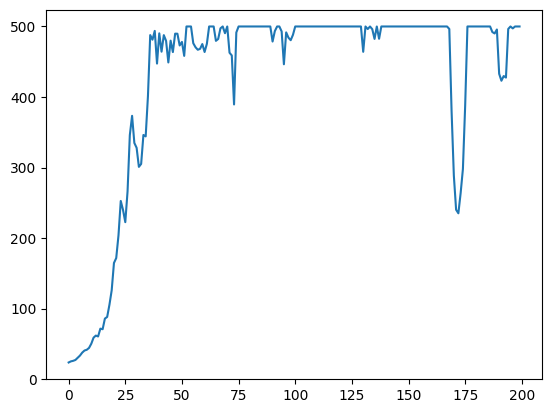

In [5]:
plt.plot(total_rewards)
plt.show()

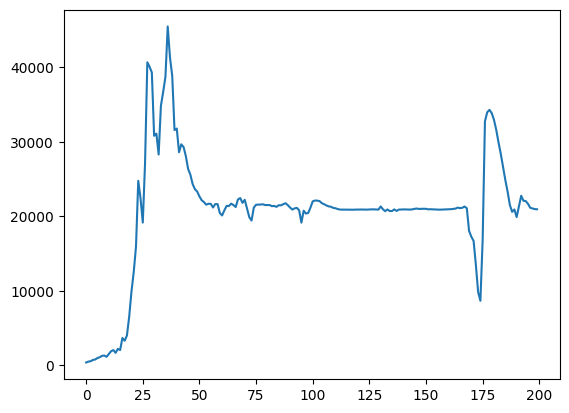

In [6]:
plt.plot(vf_losses)
plt.show()

Note that value function loss initially grows, especially when most of the policy improvement happens and total reward per episode grow the most. This is because the target for the value function mlp is non-stationary and varies the most when policy changes the most.

In [7]:
# np.save('train_stats/1run_REINFORCEBaseline.npy', np.array(total_rewards))
# np.save('train_stats/1run_vfloss_REINFORCEBaseline.npy', np.array(vf_losses))

total_rewards = np.load('train_stats/1run_REINFORCEBaseline.npy')
vf_losses = np.load('train_stats/1run_vfloss_REINFORCEBaseline.npy')

## Average over multiple runs

In [ ]:
rews = []
vf_losses = []

for i in tqdm(range(30)):
    env = gym.make('CartPole-v1')
    R = REINFORCEBaselineTrainer(env)
    curr_total_rewards, curr_vf_losses = R.train(n_epochs=100,  pi_lr = 1e-2, vf_lr = 5e-2)
    rews.append(curr_total_rewards)
    vf_losses.append(curr_vf_losses)

In [17]:
rews = np.array(rews)
vf_losses = np.array(vf_losses)

In [10]:
# np.save('train_stats/rews_30runs_REINFORCEBaseline.npy', rews)
# np.save('train_stats/vf_losses_30runs_REINFORCEBaseline.npy', vf_losses)

rews = np.load('train_stats/rews_30runs_REINFORCEBaseline.npy')
rews_nobase = np.load('train_stats/rews_30runs_REINFORCE.npy')
vf_losses = np.load('train_stats/vf_losses_30runs_REINFORCEBaseline.npy')

Let's plot the learning curve averaged over 30 runs for 100 epochs and 5000 steps per epoch. We also compare it with the training without baseline.

In [2]:
def plot(rews_list, labels, ylabel):
    
    for rews, label in zip(rews_list, labels):
        rews_mean = np.mean(rews, axis = 0)
        rews_std = np.std(rews, axis = 0)
        
        epochs = list(range(1,len(rews_mean)+1))
        plt.plot(epochs, rews_mean, label = label)
        plt.fill_between(epochs, rews_mean - rews_std, rews_mean + rews_std, color='blue', alpha=0.2)
    
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()



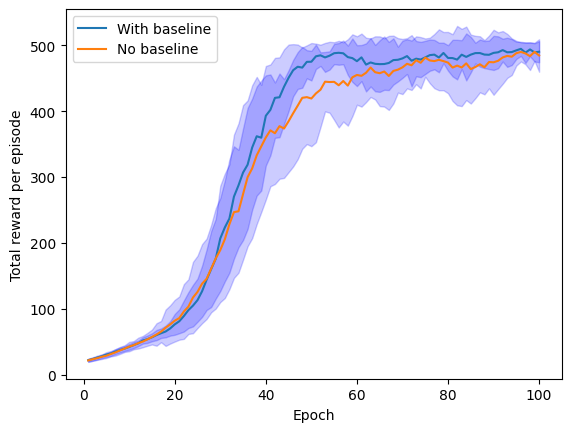

In [5]:
plot([rews, rews_nobase], ['With baseline', 'No baseline'], 'Total reward per episode')

Both average performance and variance are better with baseline. Here I used a small neural net (1 hidden layer with 32 nodes) for the value function. One can presumably improve by increasing the size of the value function neural net.

Let's also plot value function neural net losses

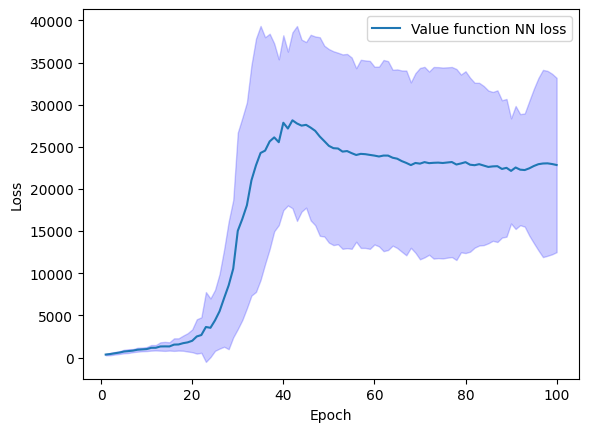

In [11]:
plot([vf_losses],['Value function NN loss'], 'Loss')

The loss grows significantly between the epochs 20 and 40. I believe this is due to the fact that the targets for the value function neural net are non-stationary. The increase in the loss is the largest precisely when the policy improves the most and therefore targets change a lot. We see on the rewards plot that total reward per episode also changes the most roughly between epochs 20 and 40.